# Entropy Regularized Wasserstein Barycenters on Graphs 
In this notebook, we'll run some experiments to epxlore how entropy regularization of the Kantorovich problem allows us to exploit a Wasserstein-like geometry for synthesis and analysis of measures. The code for the math can be found in the files `total.py` and `utils.py`.

First, we'll import the libraries needed.

In [15]:
import os
os.getcwd()
import ot
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import geopandas
from libpysal import weights
from gerrychain import Graph
import total
import utils

img_dir = os.path.join(".", "figs")

## Wasserstein vs L^2 Interpolation of Measures
First, let's look at the difference between the Wasserstein geometry and the L^2 geometry for probability distributions. The former can be thought of as a "horizontal" distance, while the latter is "vertical". In the following codeblowck, we'll interpolate two normal distributions. On the left, we have the W_2 interpolation, which moves the mass of the distribution continuously from left to right. On the right, we have the L^2 interpolation which "teleports" the mass from intial to terminal configuration.

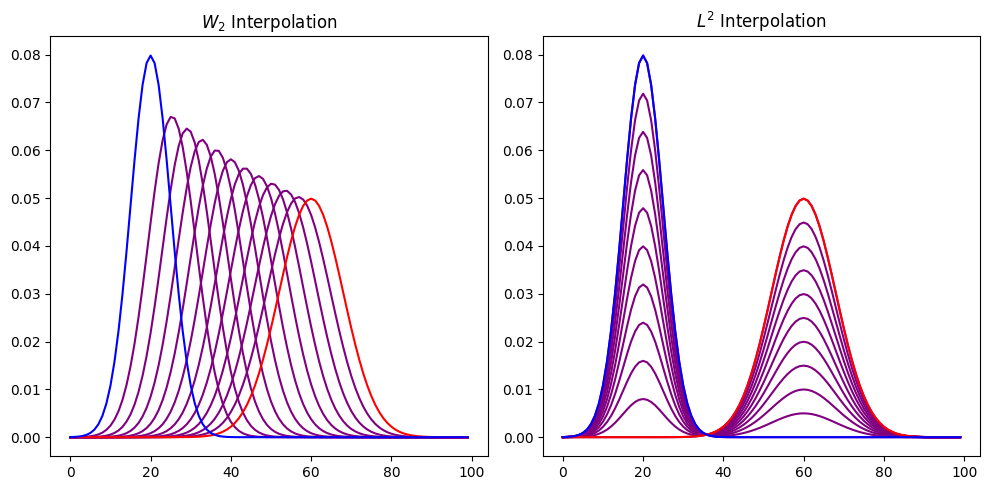

In [16]:
n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
a1 = ot.datasets.make_1D_gauss(n, m=20, s=5)  # m= mean, s= std
a2 = ot.datasets.make_1D_gauss(n, m=60, s=8)

# creating matrix A containing all distributions
A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]

# loss matrix + normalization
M = ot.utils.dist0(n)
M /= M.max()

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, num=1)
inches = 5
fig.set_size_inches(2 * inches, inches)
# wasserstein
for i in range(1,11):
    alpha = 0.1 * i  # 0<=alpha<=1
    w= np.array([1 - alpha, alpha])
    reg = 1e-3
    bary_wass = ot.bregman.barycenter(A, M, reg, w)
    ax1.plot(x, bary_wass, "purple")
ax1.plot(x, a2, color="red")
ax1.plot(x, a1, color="blue")
ax1.set_title(r"$W_2$ Interpolation")

for i in range(11):
    alpha = 0.1 * i  # 0<=alpha<=1
    w= np.array([1 - alpha, alpha])
    bary_l2 = A.dot(w)
    ax2.plot(x, bary_l2, "purple")

ax2.plot(x, a2, color="red")
ax2.plot(x, a1, color="blue")
ax2.set_title(r"$L^2$ Interpolation")

plt.savefig(os.path.join(img_dir,"interpolants.pdf"))

## Illustrate regularized and non-regularized transport plans
Now, a transport solution is defined by a plan, expressed by a matrix, that describes how much mass to move from the i-th particle of the initial distribution to the j-th particle of the terminal distribution. If the two distributions have the same number of particles, the non-regularized plan is just a permutation matrix. On the other hand, when we add the entropic term to regularize the linear program, we add a certain amount of diffusivity to the problem, and we can see this reflected in the two plans generated by the following code block. The distributions are generated and then plotted on the left. The middle is the non-regularized plan, and the right is the entropy-regularized plan.

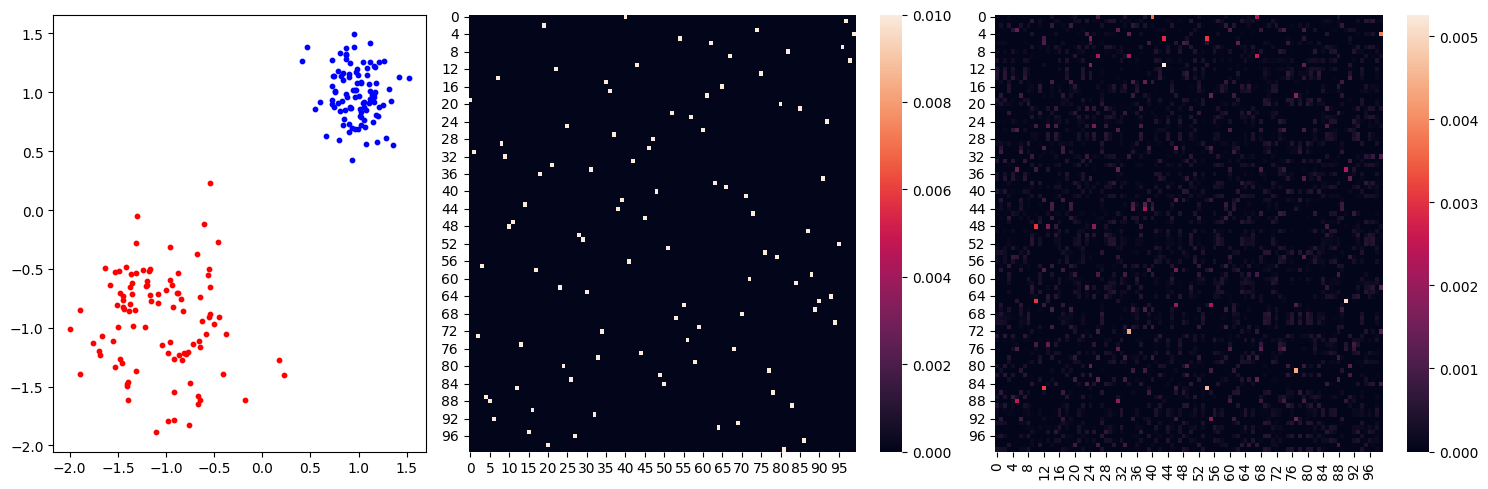

In [ ]:
n = 100
X_mean = [-1, -1]
Y_mean = [1, 1]
X_cov = [[0.25, 0], [0, 0.25]]
Y_cov = [[0.05, 0], [0, 0.05]]
X = np.random.multivariate_normal(X_mean, X_cov, n)
Y = np.random.multivariate_normal(Y_mean, Y_cov, n)
M = ot.dist(X,Y)
M.shape
a, b = np.ones((n,)) / n, np.ones((n,)) / n
G = ot.emd(a, b, M)
G_epsilon = ot.sinkhorn(a,b,M, 0.05)

fig, ax = plt.subplots(1,3, tight_layout=True,gridspec_kw={'width_ratios': [1, 1.3, 1.3]})
fig.set_size_inches(15,5)
size=10
ax[0].scatter(X.T[0], X.T[1], c='red', s=size)
ax[0].scatter(Y.T[0], Y.T[1], c='blue',s=size)
sns.heatmap(G, ax=ax[1], square=False)
sns.heatmap(G_epsilon, ax=ax[2], square=False)
plt.savefig(os.path.join(img_dir, "plans.pdf"))

## Applying the Wasserstein Geometry to graphs
Now, let's suppose that our distributiosn of intereste are supported on a discrete metric space, like a graph. For this example, we'll use the 48 contiguous United States.

/home/dcg/projects/fixed-support-barycenters/.venv/lib/python3.13/site-packages/gerrychain/graph/graph.py:266: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
/tmp/ipykernel_9450/2696423309.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.column_stack((states.centroid.x, states.centroid.y))
/tmp/ipykernel_9450/2696423309.py:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen = weights.Queen.from_dataframe(states)


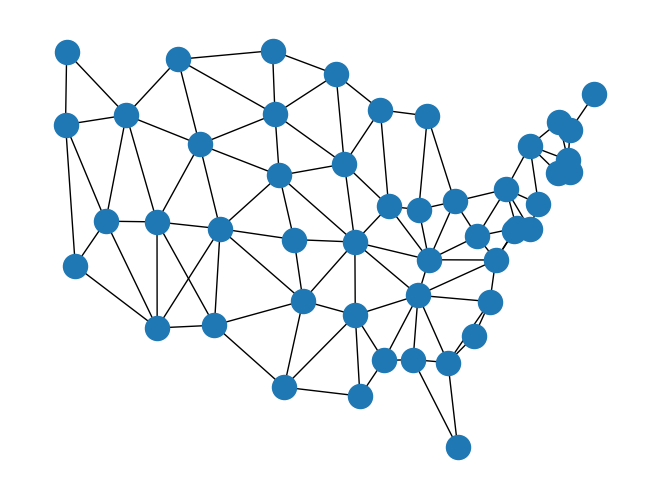

In [17]:
from utils import compute_graph_metric, form_diffusion_map_from_graph
filename = "./cces/states/states.shp"
usa_graph = Graph.from_file(filename)
states = geopandas.read_file(filename)
adj_mat = nx.adjacency_matrix(usa_graph).toarray()
centroids = np.column_stack((states.centroid.x, states.centroid.y))
queen = weights.Queen.from_dataframe(states)
graph = queen.to_networkx()
positions = dict(zip(graph.nodes, centroids))
num_nodes = len(graph.nodes)
nx.draw(graph, positions)

## Different Graph Metrics
Now one of the key ingredients to the Wasserstein geometry is the ground cost, some power of the metric that defines the geometry of the underlying space. The question how we should measure the distance between two nodes on a graph is one of interest in its own right, but for now we'll concern ourselves with just two major examples: the shortest path distance (probably the most natural metric we could imagine) and the diffusion distances, which are actually a family of distances parameterized in time. Below, we'll see how these metrics differ from each other by fixing a reference node and looking at how far away all the other nodes are.

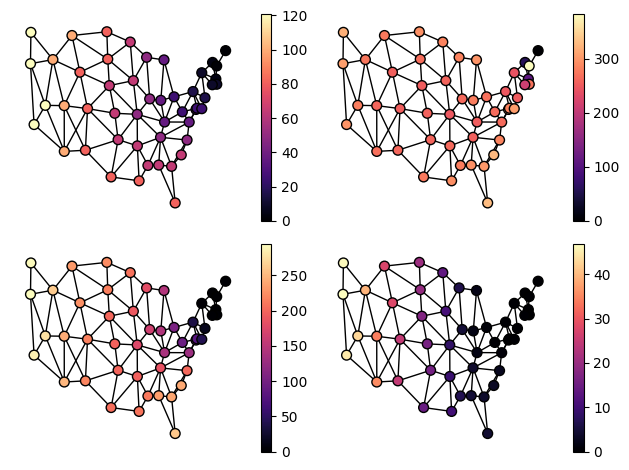

In [18]:
fig, ax = plt.subplots(2,2, tight_layout=True)
sq_shortest_path = compute_graph_metric(graph) ** 2
n = 37
size = 50
with_labels = False
cmap = "magma"

node_color = sq_shortest_path[n]
plot00 = nx.draw(
    graph, 
    positions, 
    ax=ax[0][0], 
    node_size=size, 
    with_labels=with_labels, 
    cmap=cmap,
    node_color=node_color,
    edgecolors="black",
)
vmin = min(node_color)
vmax = max(node_color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax=ax[0][0])

node_color=form_diffusion_map_from_graph(graph, 2)[n] ** 3
plot01 = nx.draw(
    graph, 
    positions, 
    ax=ax[0][1], 
    node_size=size, 
    with_labels=with_labels, 
    cmap=cmap,
    edgecolors="black",
    node_color=node_color
)
vmin = min(node_color)
vmax = max(node_color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax=ax[0][1])

node_color=form_diffusion_map_from_graph(graph, 8)[n] ** 5
plot10 = nx.draw(
    graph, 
    positions, 
    ax=ax[1][0], 
    node_size=size, 
    with_labels=with_labels, 
    cmap=cmap,
    edgecolors="black",
    node_color=node_color
)
vmin = min(node_color)
vmax = max(node_color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax=ax[1][0])

node_color = form_diffusion_map_from_graph(graph, 32)[n] ** 10
plot11 = nx.draw(
    graph, 
    positions, 
    ax=ax[1][1], 
    node_size=size, 
    with_labels=with_labels, 
    cmap=cmap,
    edgecolors="black",
    node_color=node_color
)
vmin = min(node_color)
vmax = max(node_color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, ax=ax[1][1])
plt.savefig(os.path.join(img_dir, "distances.pdf"))

## Some Helper Functions for Drawing
Here are some helper functions for drawing the illustrations. They contain no interesting mathematical content.

In [24]:
import matplotlib.animation as animation
def animate_geodesic(geodesic, metric, filename, steps=50,cmap="magma"):
    fig, ax0 = plt.subplots()
    fig.set_size_inches(10,10)
    def update(frame):
        size = 500
        nx.draw(graph, positions, ax=ax0, node_size=size, node_color=geodesic[:, frame], cmap=cmap)
        ax0.set_title(r"$W_2$ " +  f"Geodesic under {metric}\n Timestep : {frame + 1}")
    ani = animation.FuncAnimation(fig=fig, func=update, frames=steps, interval=100)
    ani.save(filename, writer='ffmpeg')
    return geodesic

def draw_fig(m0, m1, geodesic, coords, fname, cmap="magma",size=50, with_labels=False):
    fig, ax = plt.subplots(2,2, tight_layout=True)
    node_color=m0
    nx.draw(
        graph, 
        positions, 
        ax=ax[0][0], 
        node_size=size, 
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[0][0])
    
    node_color=geodesic[:,T//3]
    nx.draw(
        graph, 
        positions, 
        ax=ax[1][0], 
        node_size=size, 
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[0][1])
    
    node_color=geodesic[:,2*T//3]
    nx.draw(
        graph, 
        positions, 
        ax=ax[1][1], 
        node_size=size, 
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[1][0])
    
    node_color=m1
    nx.draw(
        graph, 
        positions, 
        ax=ax[0][1], 
        node_size=size,
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    ax[0][0].set_title(f"Reference Measure")
    ax[0][1].set_title(f"Reference Measure")
    ax[1][0].set_title(f"Actual Coordinate {0.33:}: \nRecovered Coordinate: {coords[1][1]:.4f}")
    ax[1][1].set_title(f"Actual Coordinate {0.66}: \nRecovered Coordinate {coords[2][1]:.4f}")
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[1][1])
    plt.savefig(os.path.join(img_dir, fname))

def draw_barycenter(m0, m1, m2, barycenter, coords, rc, fname, size=50, with_labels=False):
    fig, ax = plt.subplots(2,2, tight_layout=True)
    node_color=m0
    nx.draw(
        graph, 
        positions, 
        ax=ax[0][0], 
        node_size=size, 
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[0][0])
    
    node_color=m2
    nx.draw(
        graph, 
        positions, 
        ax=ax[1][0], 
        node_size=size, 
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[0][1])
    
    node_color=barycenter
    nx.draw(
        graph, 
        positions, 
        ax=ax[1][1], 
        node_size=size, 
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[1][0])
    
    node_color=m1
    nx.draw(
        graph, 
        positions, 
        ax=ax[0][1], 
        node_size=size,
        with_labels=with_labels, 
        cmap=cmap,
        edgecolors="black",
        node_color=node_color
    )
    ax[0][0].set_title(f"Reference Measure")
    ax[0][1].set_title(f"Reference Measure")
    ax[1][0].set_title(f"Reference Measure")
    ax[1][1].set_title(f"Barycentric Coordinates ({coords[0]:.2f}, {coords[1]:.2f}, {coords[2]:.2f})\n Recovered: ({rc[0]:.4f}, {rc[1]:.4f}, {rc[2]:.4f})")
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm, ax=ax[1][1])
    plt.savefig(os.path.join(img_dir, fname))

## Illustrate slices of a geodesic on a graph
Now, barycenters generalize the notion of geodesic curves in the sense that the barycenter of two measures coincides exactly with the Wasserstein interpolant. So first, let's see how these interpolants look in the graph setting, and try to recover the coordinates --- since there's only two coordinates which must sum to 1, the interpolant will be defined by a single variable that we'll call t.

computing with TOTAL implementation


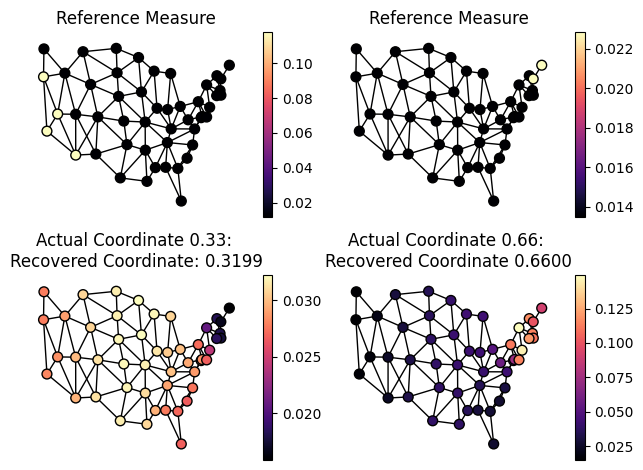

In [25]:
from total import build_geodesic
from utils import  random_geographic_concentration
c0, c1 = 15, 37
reg = .25
t = 32
T = 50
title = r"Squared Shortest Path Distance, $t = $" + f"{t}"
fname = f"{title}.mp4"
cost = form_diffusion_map_from_graph(graph, t) ** 2

mu_0 = random_geographic_concentration(adj_mat, center=c0)
mu_1 = random_geographic_concentration(adj_mat, center=c1)
measures = np.stack((mu_0, mu_1)).T
geodesic = build_geodesic(
    measures, cost, reg, method="total", steps = T, iters=2048
)
denom = 3
epsilon = .25
coords = [
total.simplex_regression(measures, geodesic[:,1], cost, epsilon),
total.simplex_regression(measures, geodesic[:,1 * T // denom], cost, epsilon),
total.simplex_regression(measures, geodesic[:,2 * T // denom], cost, epsilon),
total.simplex_regression(measures, geodesic[:,-2], cost, epsilon),
]

draw_fig(mu_0, mu_1, geodesic, coords, "sq-shortest-geodesic.pdf")

## Visualizing a regularized barycenter on a graph
Finally, let's compute the barycenter of three differnt measures and try recovering the coordinates.

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


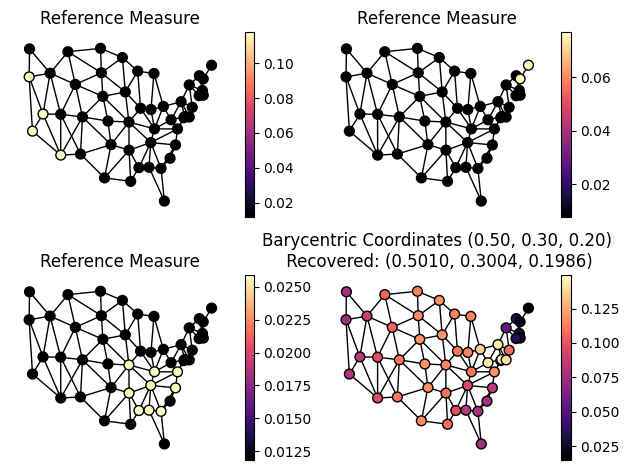

In [23]:
reg = 0.125
c0, c1, c2 = 15, 37, 22
coords = [0.5, 0.3, 0.2]
m0 = random_geographic_concentration(adj_mat, center=c0)
m1 = random_geographic_concentration(adj_mat, center=c1)
m2 = random_geographic_concentration(adj_mat, center=c2)
measures = np.stack((m0, m1, m2)).T
barycenter = total.barycenter(coords, measures, None, cost, reg)
fname = "barycenter.pdf"
rcs = total.simplex_regression(measures, barycenter, cost, reg)
draw_barycenter(m0, m1, m2, barycenter, coords, rcs, fname)